<a href="https://colab.research.google.com/github/RonnalOrtiz/First_steps/blob/main/Copia_de_Linea_Base%2028%2003%202022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.transform import resize
from sklearn.model_selection import train_test_split 
from skimage import io
from skimage.color import label2rgb
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from skimage.transform import resize, downscale_local_mean
from skimage.filters import threshold_otsu
from numpy import linalg as alg


from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from google.colab import drive
drive.mount('/content/drive')
from warnings import filterwarnings
filterwarnings('ignore')


Mounted at /content/drive


In [ ]:
def quantimage_CV(image,k):
  i = np.float32(image).reshape(-1,3)
  condition = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,15,0.5)
  rt,label,center = cv.kmeans(i, k , None, condition,10,cv.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  final_img = center[label.flatten()]
  final_img = final_img.reshape(image.shape)
  return final_img,label,center,rt

def quantimage_SK(image,k,semilla):
  i = np.float32(image).reshape(-1,3)
  model=KMeans(n_clusters=k, algorithm="full", random_state=semilla, tol=1e-5,n_init=2,max_iter=300).fit(i)
  center=np.uint8(model.cluster_centers_)
  label=model.labels_
  rt=model.inertia_
  final_img = center[label.flatten()]
  final_img = final_img.reshape(image.shape)
  return final_img,label,center,rt

def quantimage_MS(image):
  i = np.float32(image).reshape(-1,3)
  bandwidth = estimate_bandwidth(i, quantile=0.3, n_samples=10000)
  model=MeanShift(bandwidth=bandwidth,max_iter=200,bin_seeding=True).fit(i)
  center=np.uint8(model.cluster_centers_)
  label=model.labels_
  final_img = center[label.flatten()]
  final_img = final_img.reshape(image.shape)
  return final_img,label,center,model

def d_pun_rec(X):
  U=np.array([0,0,1])
  return alg.norm(np.cross(U,X))/alg.norm(U)

def thres(centros):
  n=[]
  for c in centros:
    n.append(d_pun_rec(c))
  return np.std(n)

def charac_vector(prop_vector,centros):
  rate=prop_vector[alg.norm(centros-np.array([0,0,254]),axis=1)<=10 ][0]
  cent=centros[alg.norm(centros-np.array([0,0,254]),axis=1)>=10]
  pos=np.where(prop_vector==rate)[0][0]
  vec_car=np.delete(prop_vector,pos)
  vec_car=vec_car/np.sum(vec_car)
  return vec_car, cent

In [ ]:
def segm_polen(p,Ancho ,Alto , link, groups, semilla):
  try:
    img=io.imread(link)
    img= resize(img, (Alto, Ancho),order=1, preserve_range=True)
  except:
    img= resize(link, (Alto, Ancho),order=1, preserve_range=True)

  i=int(p*Alto)
  ima=[]
  while i < (1-p)*Alto:
    j = int(p*Ancho)
    while j < (1-p)*Ancho:
      r, g, b = np.uint8(img[i, j,:])
      ima.append([r,g,b])
      j+=1
    i+=1

  ancho=int((1-2*p)*Ancho)
  alto=int((1-2*p)*Alto)
  img=np.reshape(ima,(alto,ancho,3))

  #Computes entropy to quantifies disorder.
  # TODO: STUDY SIZE OF THE MASK
  entropy_img = entropy(img[:,:,0], disk(5))

  # Computes the threshold using Otsu method
  thresh = threshold_otsu(entropy_img)

  # Binarize the entropy image 
  binary = entropy_img >= thresh+0.5

  # TODO: POLEN CAN OVERLAP LINES MORPHOLOGICAL OPERATORS MAY HELP OR SOME COLOR INFORMATION
  # Compute conected components in the binary image
  label_image = label(binary,background=True)
  image_label_overlay = label2rgb(label_image, image=binary)


  # Extract the contected component with the largest area
  maskRegion = np.full_like(label_image,0)
  for region in regionprops(label_image):
      # take regions with large enough areas
      if region.area >= 80000:
          # draw rectangle around segmented regions
          minr, minc, maxr, maxc = region.bbox
          #rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,vfill=False, edgecolor='red', linewidth=2)
          #ax.add_patch(rect)
          # Computes the mask
          maskRegion[region.coords[:,0],region.coords[:,1]] = 1

  ima_crop=np.zeros((alto,ancho,3), np.uint8)
  i=0
  while i < alto:
    j = 0
    while j < ancho:
      if maskRegion[i,j]==0:
        ima_crop[i,j,:] = img[i, j,:]
      j+=1
    i+=1
  #ima_crop=cv.cvtColor(ima_crop,cv.COLOR_RGB2HSV)

  q_ima,_,cent,_=quantimage_SK(ima_crop,20,semilla)

  t=thres(cent)
  clean_ima=np.zeros((alto,ancho,3), np.uint8)
  for i in range(alto):
    for j in range(ancho):
      if d_pun_rec(q_ima[i,j])<t*1.1:
        #clean_ima[i,j]=np.uint8([0,0,255])
        clean_ima[i,j]=np.uint8([255,255,255])
      else:
        clean_ima[i,j]=ima_crop[i,j]
        #clean_ima[i,j]=img[i,j]
  
  #Transformation of the space HSV to RGB
  clean_ima=cv.cvtColor(clean_ima,cv.COLOR_RGB2HSV)

  q_ima,lab,c,rt=quantimage_SK(clean_ima,groups+1,semilla)

  q_vector,_=np.histogram(lab,density=True, bins=groups+1)
  

  q_vector,cent=charac_vector(q_vector,c)


  return clean_ima , q_vector,np.uint8(cent),q_ima,img,rt



In [ ]:
#Data set
df=pd.read_excel("https://github.com/JuanDavid1703/PolenProject/raw/main/Images/Group/1/Juan%20Celular.xlsx")

In [ ]:
#groups=int(input("Ingrese la cantidad de grupos: "))
#ref=np.array([[0,  0, 255]])
clean,cara_vector,cent,ima_seg,im,rt=segm_polen(0.1,2000,1500,df["Link de la foto"][10],16,42)
#flat=np.float32(clean).reshape(-1,3)

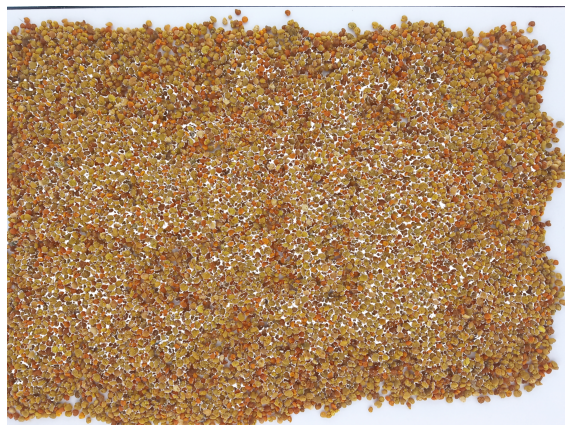

In [ ]:
# impresión de imagen limpia
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cv.cvtColor(clean,cv.COLOR_HSV2RGB))

In [ ]:
plt.imsave("/content/drive/Shareddrives/Polen_Agrosavia_Proyecto/prubapalinologia/primera.jpg",clean)

In [ ]:
#Impresion del vector de caracteríticas
print("Vector de proporciones",cara_vector)

Vector de proporciones [0.08685495 0.0751276  0.02497373 0.05732741 0.06232891 0.04042148
 0.05933454 0.08988252 0.09399417 0.08046224 0.00629476 0.06662207
 0.08357282 0.06780078 0.03884876 0.07526872 0.05338454]


Vector de proporciones [0.13210842 0.0873667  0.03596561 0.05671102 0.10894558 0.02813602
 0.04594563 0.10496824 0.12053001 0.03264254 0.03244049 0.04990733
 0.05858723 0.02356094 0.08218425]

In [ ]:
np.linalg.norm(np.array([255,255,255,])-np.array([209, 214, 235]))

64.78425734698207

In [ ]:
cent

array([[ 17, 181, 168],
       [149,  18, 189],
       [ 12, 206,  89],
       [  0,   0, 253],
       [ 16, 211, 150],
       [ 13,  82, 165],
       [ 10, 245,  83],
       [ 14, 195, 120],
       [ 18, 210, 178],
       [ 14, 232, 117],
       [ 18, 160, 194],
       [ 15, 172, 144],
       [ 19, 186, 190],
       [ 18, 130, 208],
       [ 13, 149, 115],
       [114,  28, 236],
       [ 16, 143, 166]], dtype=uint8)

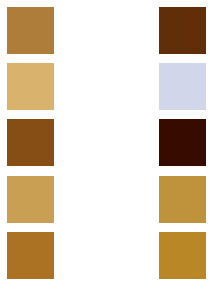

In [ ]:
#Impresión de los colores
fig,ax=plt.subplots(5,2)
fig.set_size_inches((5,5))
cont=0
for i in range(5):
  for j in range(2):
    ax[i,j].set_axis_off()
    ax[i,j].imshow(np.ones((2,2,3),dtype=np.uint8)*cent[cont])
    cont +=1

plt.show()

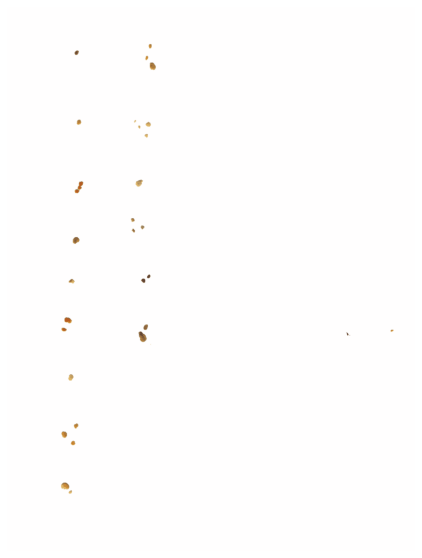

In [ ]:
# impresión de imagen segmentada
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(ima_seg)

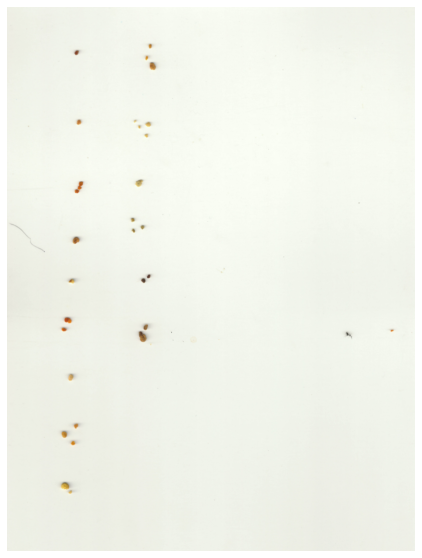

In [ ]:
# impresión de imagen original
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(im)